In [9]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import ImageFile
from tqdm import tqdm

# Sklearn
from sklearn.datasets import load_files
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.model_selection import train_test_split

# Keras 3 (correct imports)
from keras import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout, Flatten, Dense
)

from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.utils import plot_model   # updated correct location

# Updated image loader (replaces deprecated keras.preprocessing.image)
from tensorflow.keras.utils import load_img, img_to_array



In [10]:
from pathlib import Path
TEST_DIR = "./dataset/imgs/test"
TRAIN_DIR = "./dataset/imgs/train"
MODEL_PATH = "./model/vgg16/shallow_deep"
PICKLE_PATH = Path("./pickle_files")
TEST_CSV_PATH = "./csv_files/test.csv"
TRAIN_CSV_PATH = "./csv_files/train.csv"

In [11]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

In [12]:
data_train = pd.read_csv(TRAIN_CSV_PATH)
data_test = pd.read_csv(TEST_CSV_PATH)

In [13]:
# 1. Extract class names in sorted order
labels_list = sorted(data_train['ClassName'].unique())

# 2. Create mapping: ClassName → ID
labels_id = {label_name: idx for idx, label_name in enumerate(labels_list)}
print("Label mapping:", labels_id)

# 3. Replace class names with numeric IDs
data_train['ClassName'] = data_train['ClassName'].map(labels_id)

# 4. Convert numeric labels → one-hot
labels = to_categorical(data_train['ClassName'])
print("One-hot shape:", labels.shape)

# 5. Save mapping to pickle
with open(os.path.join(PICKLE_PATH, "labels_list_vgg16.pkl"), "wb") as handle:
    pickle.dump(labels_id, handle)


Label mapping: {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
One-hot shape: (22424, 10)


In [14]:
def path_to_tensor(img_path):
    """Load single image and convert to 4D tensor."""
    img_path = str(img_path)  # Windows-safe path
    img = load_img(img_path, target_size=(64, 64))
    x = img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Load all image paths → stacked tensor."""
    list_of_tensors = []
    for img_path in tqdm(img_paths, desc="Loading images"):
        list_of_tensors.append(path_to_tensor(img_path))
    return np.vstack(list_of_tensors)

# train-test split
xtrain, xtest, ytrain, ytest = train_test_split(
    data_train.iloc[:, 0].astype(str),   # make sure paths are strings
    labels,
    test_size=0.2,
    random_state=42
)

# convert image paths → images
train_tensors = paths_to_tensor(xtrain).astype("float32") / 255.0 - 0.5
valid_tensors = paths_to_tensor(xtest).astype("float32") / 255.0 - 0.5

Loading images: 100%|██████████| 4485/4485 [00:04<00:00, 942.05it/s]


In [15]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

561/561 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step


In [17]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [18]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [19]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [20]:
vgg16_model_modified = Sequential()
vgg16_model_modified.add(Flatten(input_shape=train_features.shape))
vgg16_model_modified.add(Dense(500, activation='relu',kernel_initializer='glorot_normal'))
vgg16_model_modified.add(Dropout(0.5))
vgg16_model_modified.add(Dense(10, activation='softmax',kernel_initializer='glorot_normal'))

vgg16_model_modified.summary()

c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029,510 (3.93 MB)

 Trainable params: 1,029,510 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
vgg16_model_modified.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
filepath = os.path.join(MODEL_PATH,"Vgg16_shallow_deep_best_model.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
model_history = vgg16_model_modified.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=75, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/75
1105/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4544 - loss: 1.6222
Epoch 1: val_accuracy improved from -inf to 0.68450, saving model to ./model/vgg16/shallow_deep\Vgg16_shallow_deep_best_model.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4568 - loss: 1.6146 - val_accuracy: 0.6845 - val_loss: 0.8659
Epoch 2/75
1102/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.6166
Epoch 2: val_accuracy improved from 0.68450 to 0.88183, saving model to ./model/vgg16/shallow_deep\Vgg16_shallow_deep_best_model.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7897 - loss: 0.6158 - val_accuracy: 0.8818 - val_loss: 0.3742
Epoch 3/75
1108/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8510 - loss: 0.4533
Epoch 3: val_accuracy improved from 0.88183 to 0.93445, saving model to ./model/vgg16/shallow_deep\Vgg16_shallow_deep_best_model.keras
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8511 - loss: 0.4531 - val_accuracy: 0.9

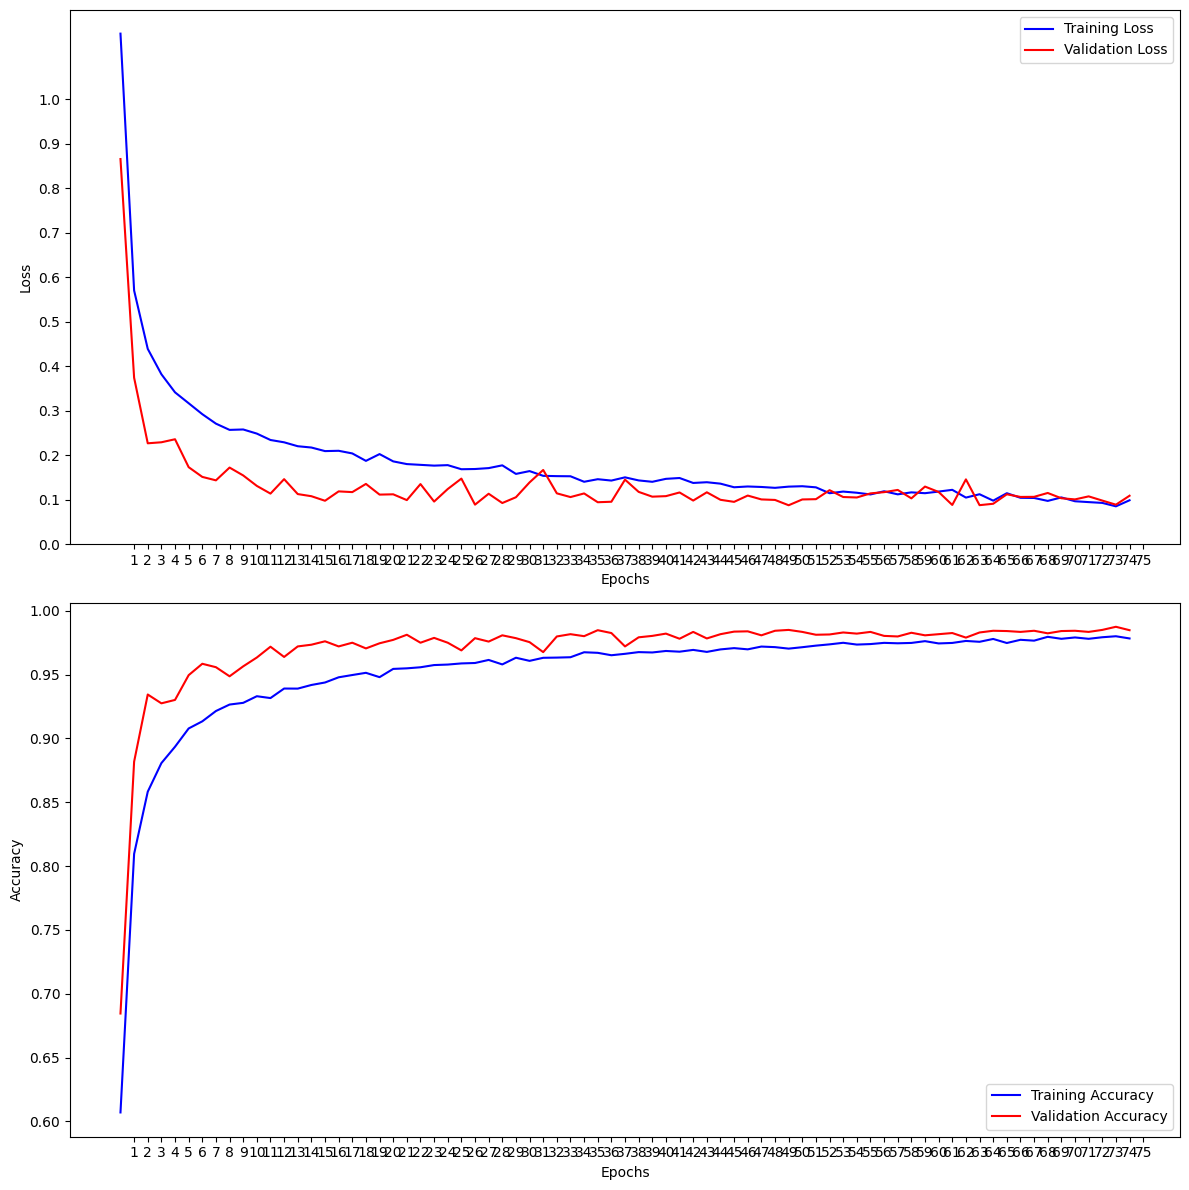

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# ----- LOSS -----
ax1.plot(model_history.history['loss'], color='b', label="Training Loss")
ax1.plot(model_history.history['val_loss'], color='r', label="Validation Loss")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax1.set_xticks(np.arange(1, len(model_history.history['loss']) + 1, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.legend()

# ----- ACCURACY -----
ax2.plot(model_history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r', label="Validation Accuracy")

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

ax2.set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, 1))
ax2.legend()

plt.tight_layout()
plt.show()


In [59]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"vgg16_shallow_deep_non_batch_confusion_matrix.png"))
    return fig

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def print_heatmap(ytrue, ypred, class_names):

    # FIX: Convert one-hot ytrue → integer labels
    if len(ytrue.shape) > 1 and ytrue.shape[1] > 1:
        ytrue = np.argmax(ytrue, axis=1)

    # Convert predicted probabilities → class index
    pred_labels = np.argmax(ypred, axis=1)

    # Raw confusion matrix
    cm = confusion_matrix(ytrue, pred_labels)

    # Normalize → percentage
    cm_percent = (cm / cm.sum(axis=1, keepdims=True)) * 100
    cm_percent = cm_percent.astype(int)
    heatmap = print_confusion_matrix(cm_percent, class_names, figsize=(18,10), fontsize=20)


In [70]:
class_names = [name for name, idx in sorted(labels_id.items(), key=lambda x: x[1])]


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


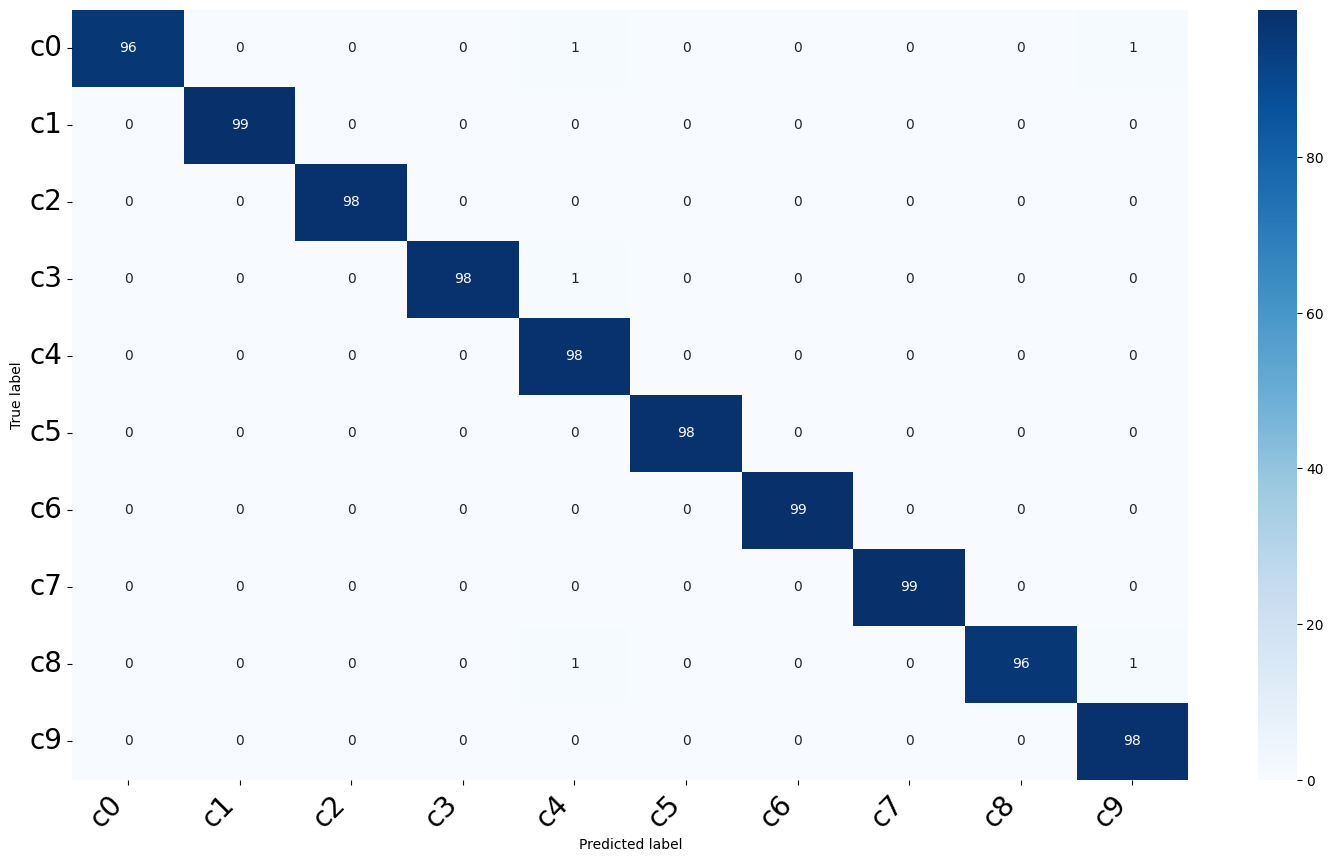

In [71]:
ypred = vgg16_model_modified.predict(valid_vgg16, verbose=1)
print_heatmap(ytest, ypred, class_names)


In [73]:
ypred_class = np.argmax(ypred,axis=1)
yval = ytest

In [74]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.984838
Precision: 0.985082
Recall: 0.984838
F1 score: 0.984866
